In [1]:
#  !pip install torch

In [2]:
# !pip install --upgrade typing_extensions

In [3]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Define a single directory to save everything
save_dir = '/content/drive/My Drive/1DPINN_NEW'
os.makedirs(save_dir, exist_ok=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


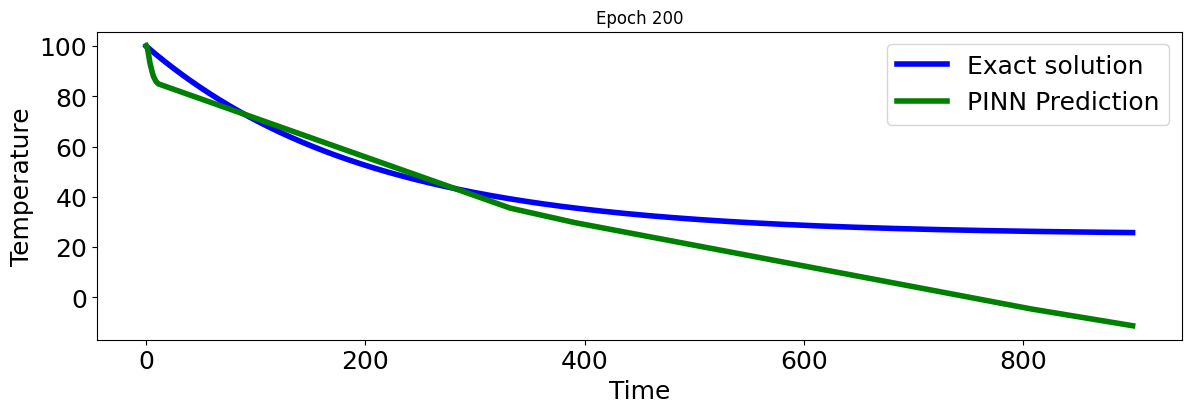

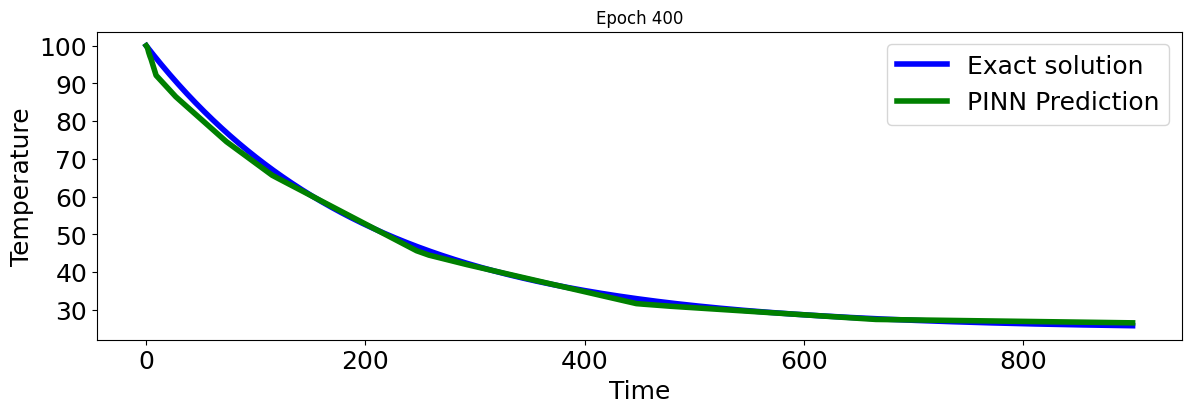

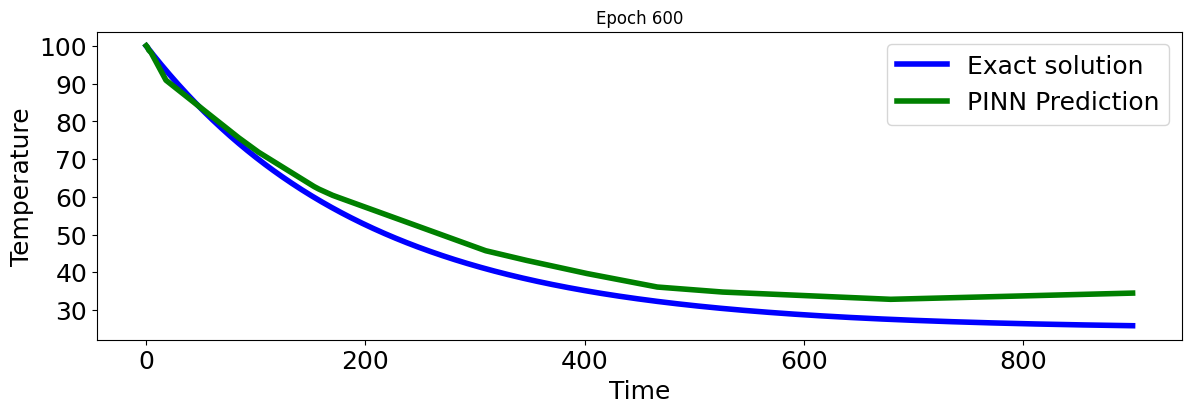

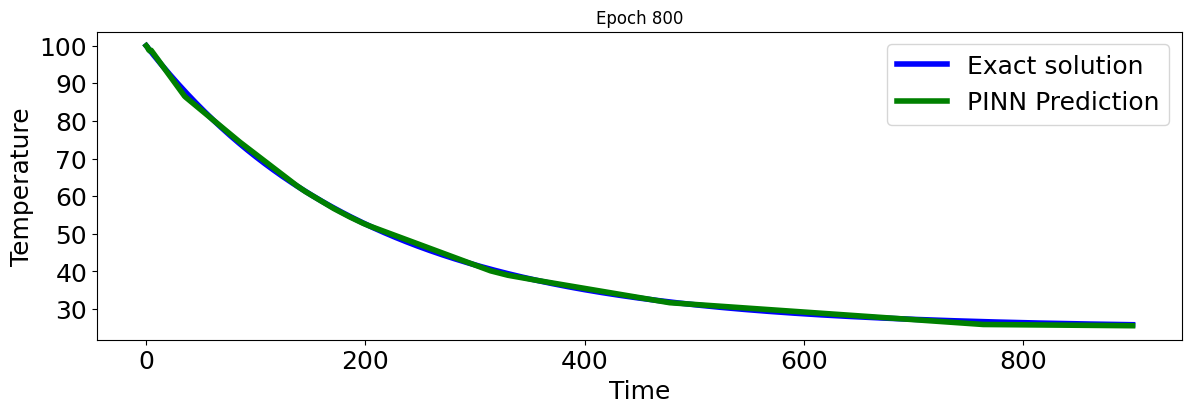

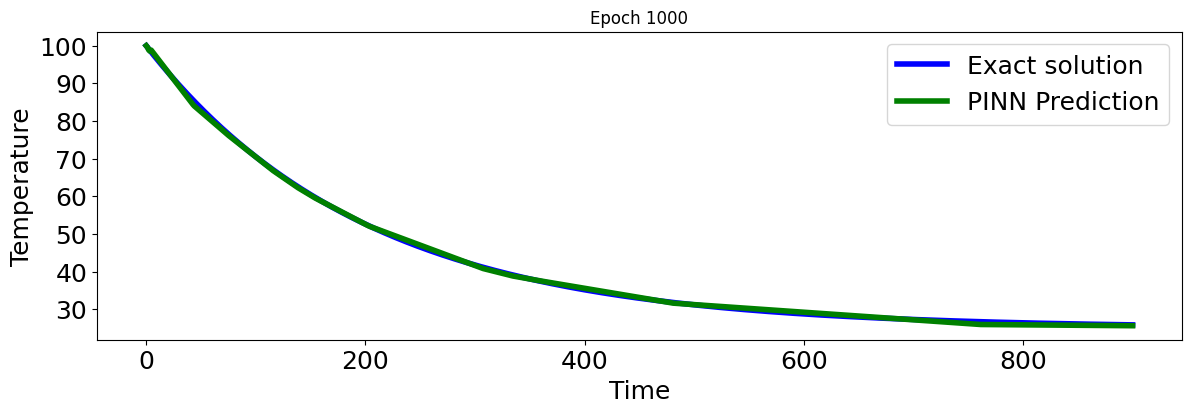

Training complete. Model and all losses saved.


In [4]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Set up environment
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
torch.manual_seed(123)  # Set random seed for reproducibility

# Define a single directory to save everything
save_dir = '/content/drive/My Drive/1DPINN_NEW'
os.makedirs(save_dir, exist_ok=True)

# ====================
# Define Function
# ====================
def calculate_temperature(T_0, T_env, r, time):
    """Computes the exact solution to Newton's Law of Cooling."""
    return T_env + (T_0 - T_env) * torch.exp(-r * time)

# ====================
# Define Neural Network
# ====================
class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        x1 = self.relu(self.fc1(x))
        x2 = self.relu(self.fc2(x1)) + x1  # Skip connection
        x3 = self.fc3(x2)
        return x3

# ====================
# Define Model & Optimizer
# ====================
input_size = 1
hidden_size = 44
output_size = 1
model = SimpleNN(input_size, hidden_size, output_size)
optimizer = optim.Adam(model.parameters(), lr=1e-2)

# Learning Rate Scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.4, patience=100, verbose=True)

# ====================
# Define Parameters & Training Data
# ====================
T_env = 25  # Environment temperature
T_0 = 100   # Initial temperature
r = 0.005   # Cooling rate

# Define boundary point (Initial condition at t=0)
time_boundary = torch.tensor([[0.0]], requires_grad=True)

# # Improved collocation point sampling (More points near t=0)

time_physics = torch.cat([
    torch.linspace(0, 300, 600),  # Higher density at early time
    torch.linspace(300, 600, 300),
    torch.linspace(600, 900, 200)
]).view(-1,1).requires_grad_(True)



# Generate exact solution for comparison
time_test = torch.linspace(0, 900, 800).view(-1,1)
u_exact = calculate_temperature(T_0, T_env, r, time_test)

# ====================
# Train the PINN
# ====================
losses_initial, losses_boundary, losses_pde, losses_total, l2_errors = [], [], [], [], []
for epoch in range(1000):
    optimizer.zero_grad()

    # Initial Condition Loss (u(0) = T_0)
    u_initial = model(time_boundary)
    loss_initial = (torch.squeeze(u_initial) - T_0) ** 2

    # Boundary Loss (Ensuring correct derivative at t=0)
    dudt_initial = torch.autograd.grad(u_initial, time_boundary, torch.ones_like(u_initial), create_graph=True)[0]
    loss_boundary = (torch.squeeze(dudt_initial) - (-r * (T_0 - T_env))) ** 2

    # PDE Physics Loss (du/dt = -r * (u - T_env))
    u_physics = model(time_physics)
    dudt_physics = torch.autograd.grad(u_physics, time_physics, torch.ones_like(u_physics), create_graph=True)[0]
    loss_pde = torch.mean((dudt_physics - (-r * (u_physics - T_env)))**2)


    # **Improved Adaptive Loss Weights (Higher weight on Initial Loss initially)**
    lambda1 = 1 / (loss_initial.item() + 1)
    lambda2 = 1 / (loss_boundary.item() + 1)
    lambda3 = 1 / (loss_pde.item() + 1)

    # Reduce lambda1 over time to balance learning
    lambda1 *= max(0.1, 1.0 - epoch / 4000)

    # Compute total loss
    loss_total = lambda1 * loss_initial + lambda2 * loss_boundary + lambda3 * loss_pde
    loss_total.backward()
    optimizer.step()
    scheduler.step(loss_total.item())

    # Store loss values
    losses_initial.append(loss_initial.item())
    losses_boundary.append(loss_boundary.item())
    losses_pde.append(loss_pde.item())
    losses_total.append(loss_total.item())

    # Compute L2 error
    u_pred = model(time_test).detach()
    l2_error = torch.norm(u_pred - u_exact, p=2) / torch.norm(u_exact, p=2)
    l2_errors.append(l2_error.item())

    # Save model & plot every 200 epochs
    if (epoch + 1) % 200 == 0:
        # print(f"Epoch {epoch+1} - Initial Loss: {loss_initial.item():.6f}, "
        #       f"Boundary Loss: {loss_boundary.item():.6f}, "
        #       f"PDE Loss: {loss_pde.item():.6f}, "
        #       f"Total Loss: {loss_total.item():.6f}, "
        #       f"L2 Error: {l2_error.item():.6f}")

        # Save model
        torch.save(model.state_dict(), f'{save_dir}/trained_model_epoch_{epoch+1}.pth')

        # Plot results
        plt.figure(figsize=(14, 4))
        plt.plot(time_test[:,0], u_exact[:,0], label="Exact solution", color='b', linewidth=4)
        plt.plot(time_test[:,0], u_pred[:,0], label="PINN Prediction", color='g', linewidth=4)
        plt.xlabel('Time', fontsize=18)
        plt.ylabel('Temperature', fontsize=18)
        plt.xticks(fontsize=18)
        plt.yticks(fontsize=18)
        plt.legend(fontsize=18)
        plt.title(f"Epoch {epoch+1}")
        plt.savefig(f'{save_dir}/PINN_prediction_epoch_{epoch+1}.png', dpi=400)
        plt.show()
        plt.close()

# ====================
# Save Losses
# ====================
torch.save(model.state_dict(), f'{save_dir}/trained_model_final.pth')

# Save all loss components per epoch
with open(f'{save_dir}/losses_log.txt', 'w') as f:
    f.write("Epoch, Initial Loss, Boundary Loss, PDE Loss, Total Loss, L2 Error\n")
    for epoch in range(len(losses_total)):
        l2_error = l2_errors[epoch] if epoch < len(l2_errors) else "N/A"
        f.write(f"{epoch+1}, {losses_initial[epoch]}, {losses_boundary[epoch]}, {losses_pde[epoch]}, {losses_total[epoch]}, {l2_error}\n")

print("Training complete. Model and all losses saved.")

In [5]:
# # ====================
# # Part 6: Plot Losses
# # ====================
# plt.figure(figsize=(10, 5))

# # Plot each loss component
# plt.plot(losses_initial, label="Initial Loss", linestyle="-", color="b")
# plt.plot(losses_boundary, label="Boundary Loss", linestyle="-", color="r")
# plt.plot(losses_pde, label="PDE Loss", linestyle="-", color="g")
# plt.plot(losses_total, label="Total Loss", linestyle="-", color="k")  # Black for total loss

# plt.xlabel("Epochs")
# plt.ylabel("Loss")
# plt.yscale("log")  # Log scale to better visualize differences
# plt.title("Loss Components Over Training")
# plt.legend()
# plt.grid(True)

# # Save and show plot
# plt.savefig("loss_plot.png", dpi=300)
# plt.show()


In [6]:
# ====================
# Part 6: Compute L2 Error
# ====================
u_pred = model(time_test).detach()
l2_error = torch.norm(u_pred - u_exact, p=2) / torch.norm(u_exact, p=2)

print(f"L2 Error: {l2_error.item():.6f}")


L2 Error: 0.008096


Plot saved at: /content/drive/My Drive/1DPINN_NEW/loss_convergence_1D.png


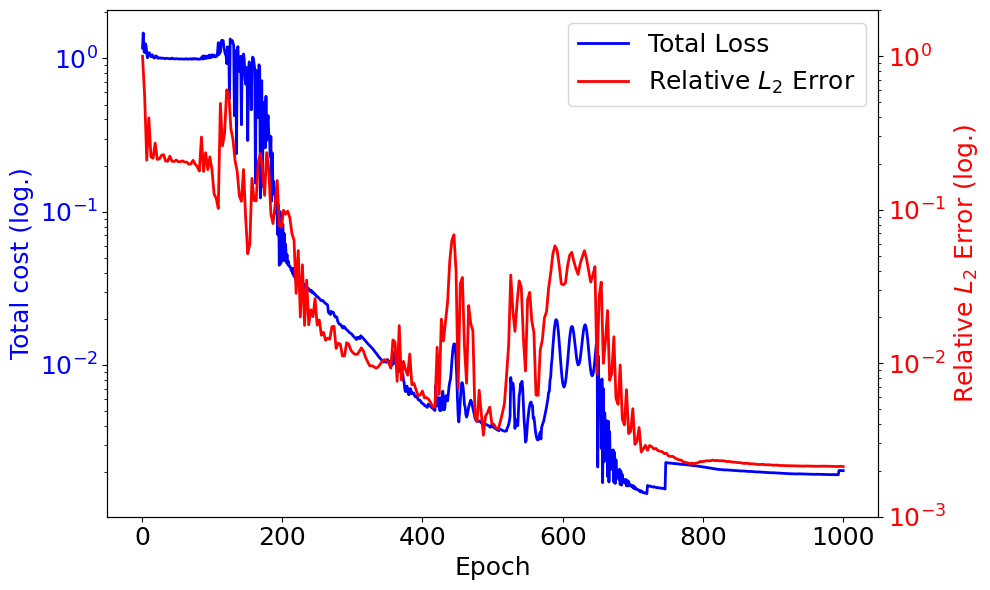

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import os

# Ensure save directory exists
save_dir = '/content/drive/My Drive/1DPINN_NEW'
os.makedirs(save_dir, exist_ok=True)

# Normalize L2 error safely
relative_L2_error = np.array(l2_errors) / np.max(l2_errors)  # Normalize w.r.t. max value

# Define iterations based on the total number of epochs (4000)
iterations = np.arange(1, len(losses_total) + 1)

# Slice both iterations and relative_L2_error using the same step size
iterations_sliced = iterations[::3]  # Slice every third iteration
relative_L2_error_sliced = relative_L2_error[::3]  # Slice L2 errors to match iterations

# Ensure both have the same length
min_len = min(len(iterations_sliced), len(relative_L2_error_sliced))
iterations_sliced = iterations_sliced[:min_len]
relative_L2_error_sliced = relative_L2_error_sliced[:min_len]

# Create figure and primary y-axis
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot Total Loss on primary y-axis
ax1.set_xlabel('Epoch', fontsize=18)
ax1.set_ylabel('Total cost (log.)', color='blue', fontsize=18)

# Plot Total Loss across all epochs
total_loss_plot, = ax1.plot(iterations, losses_total, label='Total Loss', color='blue', linewidth=2, linestyle='solid')

ax1.set_yscale('log')  # Set y-axis to logarithmic scale
ax1.tick_params(axis='y', labelcolor='blue', labelsize=18)
ax1.tick_params(axis='x', labelsize=18)  # Set x-axis tick labels

# Create secondary y-axis for Relative L2 Error
ax2 = ax1.twinx()
ax2.set_ylabel('Relative $L_2$ Error (log.)', color='red', fontsize=18)

# Now plot the data
error_plot, = ax2.plot(iterations_sliced, relative_L2_error_sliced, label='Relative $L_2$ Error', linestyle='solid', color='red', linewidth=2)

ax2.set_yscale('log')  # Set log scale for better visibility
ax2.set_ylim(1e-3, 2)  # Adjust range manually if needed
ax2.tick_params(axis='y', labelcolor='red', labelsize=18)

# Add legend with updated font size, referencing the plot objects
plt.legend(handles=[total_loss_plot, error_plot], loc='upper right', fontsize=18)

# Adjust layout to prevent clipping
fig.tight_layout()

# Save the figure
save_path = os.path.join(save_dir, "loss_convergence_1D.png")
plt.savefig(save_path, dpi=300, bbox_inches='tight')
print(f"Plot saved at: {save_path}")

# Show the plot
plt.show()
